In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import seaborn as sns

import src.metrics as metrics
import src.kernels as kernels
import src.bootstrap as boot

In [2]:
np.random.seed(2024)

In [3]:
# dim = 1
# n = 1000

# x_sample = np.random.multivariate_normal(np.zeros((dim,)), np.eye(dim), n)

# y_sample = np.random.multivariate_normal(np.zeros((dim,)), np.eye(dim), n)

In [102]:
def mmd_experiment_single(kernel_class, Xs, Ys, theta, nboot=500, alpha=0.05, theta_prime=0., beta=.2, quantile=None, method="auto"):
    res = {
        "deviation": {"val": [], "threshold": [], "rej": []},
        "deviation_proper": {"val": [], "threshold": [], "rej": []},
        "boot": {"val": [], "threshold": [], "rej": [], "boot_stats": [], "pval": []},
        "boot_power": {"val": [], "threshold": [], "rej": [], "pval": [], "boot_stats": [], "beta": beta, "theta": []},
        "original": {"val": [], "threshold": [], "rej": [], "pval": [], "boot_stats": []},
        "CLT": {"val": [], "threshold": [], "rej": [], "var": []},
        "CLT_proper": {"val": [], "threshold": [], "rej": [], "var": []},
    }
    for X, Y in tqdm(zip(Xs, Ys), total=Xs.shape[0]):
        kernel = kernel_class(sigma_sq=2.)
        mmd = metrics.MMD(kernel)
        val = mmd(X, Y)
        val = val**0.5
        threshold = mmd.test_threshold(X.shape[0])

        if method == "classic":
            # 1. deviation bound
            rej = mmd.reverse_test(X, Y, theta, alpha, method="deviation")
    
            res["deviation"]["val"].append(val)
            res["deviation"]["threshold"].append(threshold)
            res["deviation"]["rej"].append(rej)

            # 2. deviation bound
            rej = mmd.reverse_test(X, Y, theta, alpha, method="deviation_proper")
    
            res["deviation_proper"]["val"].append(val)
            res["deviation_proper"]["threshold"].append(threshold)
            res["deviation_proper"]["rej"].append(rej)

            # 3. full bootstrap
            boot_stats = mmd.test_threshold(X.shape[0], X, Y=Y, nboot=nboot, method="bootstrap_efron_full")
            boot_stats = np.array(boot_stats)**0.5
            quantile = np.quantile(boot_stats, 1 - alpha)
            # boot_rej = float(max(0, theta - val) > quantile)
    
            test_stat = theta - val
            # test_stat_boot = theta - boot_stats
            # boot_pval = (1 + np.sum(test_stat <= test_stat_boot)) / (1 + test_stat_boot.shape[0])
            boot_pval = np.sum(test_stat <= boot_stats) / boot_stats.shape[0]
            boot_rej = np.float32(boot_pval < alpha)
    
            res["boot"]["val"].append(val)
            res["boot"]["rej"].append(boot_rej)
            res["boot"]["threshold"].append(quantile)
            res["boot"]["pval"].append(boot_pval)
            res["boot"]["boot_stats"].append(boot_stats)

            # 4. CLT
            rej = mmd.reverse_test(X, Y, theta, alpha, method="CLT")
    
            res["CLT"]["val"].append(mmd.u_stat_val)
            res["CLT"]["threshold"].append(mmd.clt_threshold)
            res["CLT"]["rej"].append(rej)
            res["CLT"]["var"].append(mmd.var_val)

            # 4. CLT proper std
            rej = mmd.reverse_test(X, Y, theta, alpha, method="CLT_proper")
    
            res["CLT_proper"]["val"].append(mmd.u_stat_val)
            res["CLT_proper"]["threshold"].append(mmd.clt_threshold)
            res["CLT_proper"]["rej"].append(rej)
            res["CLT_proper"]["var"].append(mmd.var_val)

        elif method == "auto":
            # 5. full bootstrap with power guarantee
            boot_stats = mmd.test_threshold(X.shape[0], X, Y=Y, nboot=nboot, method="bootstrap_efron_full")
            boot_stats = np.array(boot_stats)**0.5
    
            gamma_beta = np.quantile(boot_stats, 1 - beta)
            gamma_alpha = np.quantile(boot_stats, 1 - alpha)
            theta_power = theta_prime + gamma_alpha + gamma_beta
            
            test_stat_power = theta_power - val
            boot_pval_power = np.sum(test_stat_power <= boot_stats) / boot_stats.shape[0]
            boot_rej_power = np.float32(boot_pval_power < alpha)
            
            res["boot_power"]["val"].append(val)
            res["boot_power"]["rej"].append(boot_rej_power)
            res["boot_power"]["threshold"].append(quantile)
            res["boot_power"]["pval"].append(boot_pval_power)
            res["boot_power"]["boot_stats"].append(boot_stats)
            res["boot_power"]["theta"].append(theta_power)

        elif method == "original":
            # 6. standard simple MMD test
            # #! median heuristic
            # kernel = kernel_class(med_heuristic=True, X=X, Y=Y)
            # mmd = metrics.MMD(kernel)

            wild_boot = boot.WildBootstrap(mmd, ndraws=nboot)
            boot_stats, test_stat = wild_boot.compute_bootstrap(X, Y)
            boot_stats, test_stat = boot_stats**0.5, test_stat**0.5
            orig_pval = (1 + np.sum(test_stat <= boot_stats)) / (1 + boot_stats.shape[0])
            orig_rej = np.float32(orig_pval < alpha)
            
            res["original"]["val"].append(val)
            res["original"]["rej"].append(orig_rej)
            res["original"]["pval"].append(orig_pval)
            res["original"]["boot_stats"].append(boot_stats)
    
    return res

def mmd_experiment(kernel_class, Xs, Ys, theta, keys, theta_prime=0, beta=None, nboot=500, quantiles=None, method="auto"):
    """
    Xs: [array(nrep, n, d), ...]
    Ys: [array(nrep, n, d), ...]
    """
    res = {}
    quantiles = quantiles if quantiles is not None else [None] * len(keys)
    
    for Xs_i, Ys_i, kk, qq in zip(Xs, Ys, keys, quantiles):
        print("key:", kk)
        res[kk] = mmd_experiment_single(
            kernel_class, Xs_i, Ys_i, theta, theta_prime=theta_prime, beta=beta, nboot=nboot, quantile=qq, method=method,
        )

    return res

def generate_data_and_quantiles(n, dim, population_mmd_ls, nrep, nstats_ora=None, ora_size=10000, mean_ls=None):
    if mean_ls is None:
        shift_sq_ls = [population_mmd_inverse(v, dim, 1.) for v in population_mmd_ls]
        print("shift_ls:", [ss**0.5 for ss in shift_sq_ls])
        mean_ls = [np.eye(dim)[0] * ss**0.5 for ss in shift_sq_ls]
    else:
        print("mean_ls", np.array(mean_ls))
    
    Xs_ls = []
    Ys_ls = []
    quantiles = []
    stats_all_ls = []
    
    for mean2 in mean_ls:
        ### Gaussian loc
        mean1 = np.zeros((dim,))
        # mean2 = np.eye(dim)[0] * shift_sq**0.5
        
        Xs = np.random.multivariate_normal(mean1, np.eye(dim), (nrep, n))
        Ys = np.random.multivariate_normal(mean2, np.eye(dim), (nrep, n))
        ###
    
        Xs_ls.append(Xs)
        Ys_ls.append(Ys)

        if nstats_ora is not None:
            # compute true quantiles
            Y = np.random.multivariate_normal(mean1, np.eye(dim), (ora_size,))
            
            stat_ls = []
            kernel = kernels.RBF(sigma_sq=2.)
            mmd = metrics.MMD(kernel)
            Xs = np.random.multivariate_normal(mean1, np.eye(dim), (nstats_ora, n))
            for i in trange(nstats_ora):
                X = Xs[i]
                stat_ls.append(mmd(X, Y)**0.5)
    
            quantile = np.quantile(stat_ls, 0.95)
            quantiles.append(quantile)
            stats_all_ls.append(stat_ls)

    data = {"Xs_ls": Xs_ls, "Ys_ls": Ys_ls, "quantiles": quantiles, "stats_all_ls": stats_all_ls, "mean_ls": mean_ls}
    return data


In [5]:
def population_mmd(mean, bandwidth_sq):
    """Compute population MMD under a mean-shift Gaussians setup
    """
    d = mean.shape[-1]
    mean_norm_sq = np.sum(mean**2)
    c = 2 * (bandwidth_sq / (2. + bandwidth_sq))**(d/2)
    mmd_sq = c * (1 - np.exp(- mean_norm_sq / (2 * (2 + bandwidth_sq))))
    return mmd_sq**0.5

def population_mmd_inverse(val, d, bandwidth_sq):
    """Compute the \| \mu \|_2^2 required for the population MMD 
    under a mean-shift Gaussians setup to equal to a given value.
    """
    mmd_sq = val**2
    c = 2 * (bandwidth_sq / (2. + bandwidth_sq))**(d/2)
    return -2. * (2 + bandwidth_sq) * np.log(1 - mmd_sq / c)

# Deviation bound

In [94]:
np.random.seed(2024)

In [95]:
nrep = 10
n = 1000
dim = 1
mean1 = np.zeros((dim,)) + 1. # data
mean2 = np.zeros((dim,)) # model

### Gaussian loc
Xs = np.random.multivariate_normal(mean1, np.eye(dim), (nrep, n))

Ys = np.random.multivariate_normal(mean2, np.eye(dim), (nrep, n))
###

kernel_class = kernels.RBF

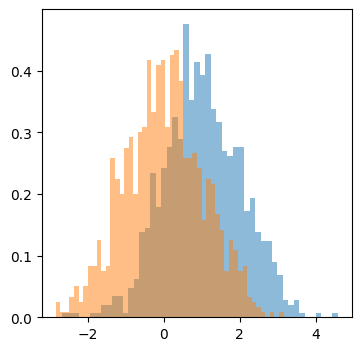

In [96]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
_ = ax.hist(Xs[0, :, 0], bins=50, label="X", alpha=0.5, density=True)
_ = ax.hist(Ys[0, :, 0], bins=50, label="Y", alpha=0.5, density=True)

In [97]:
theta = 1.
res = mmd_experiment_single(kernel_class, Xs, Ys, theta=theta, nboot=500)

  0%|          | 0/10 [00:00<?, ?it/s]

In [98]:
res["deviation"]["val"]

[0.1720179636345991,
 0.18428476926383563,
 0.19582963197821102,
 0.16876194066065464,
 0.18649441828899527,
 0.17913646195417887,
 0.18342694734633536,
 0.1783882833690058,
 0.1668056666349813,
 0.17507306934642775]

In [109]:
np.sum((np.eye(dim)[:1, 0] * 1.)**2)

1.0

In [110]:
print(population_mmd(mean1, 1.))
print(np.mean(res["deviation"]["val"]))

0.17726763491986192
0.17902191524772246


In [111]:
population_mmd_inverse(population_mmd(mean1, 1.), dim, 1.)

0.9999999999999996

In [163]:
np.random.seed(2024)

In [164]:
nrep = 100
population_mmd_ls = [1e-1, 2e-1, 3e-1, 3.5e-1, 4e-1, 4.5e-1, 5e-1, 7.5e-1, 1.]
shift_sq_ls = [population_mmd_inverse(v, dim, 1.) for v in population_mmd_ls]

Xs_ls = []
Ys_ls = []

for shift_sq in shift_sq_ls:
    ### Gaussian loc
    mean1 = np.eye(dim)[:1, 0] * shift_sq**0.5
    mean2 = np.zeros((dim,))

    Xs = np.random.multivariate_normal(mean1, np.eye(dim), (nrep, n))
    Ys = np.random.multivariate_normal(mean2, np.eye(dim), (nrep, n))
    ###

    Xs_ls.append(Xs)
    Ys_ls.append(Ys)

kernel_class = kernels.RBF

keys = population_mmd_ls

In [165]:
theta = 0.5
res = mmd_experiment(kernel_class, Xs_ls, Ys_ls, theta=theta, keys=keys, nboot=500)

key: 0.1


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.2


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.3


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.35


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.4


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.45


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.5


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.75


  0%|          | 0/100 [00:00<?, ?it/s]

key: 1.0


  0%|          | 0/100 [00:00<?, ?it/s]

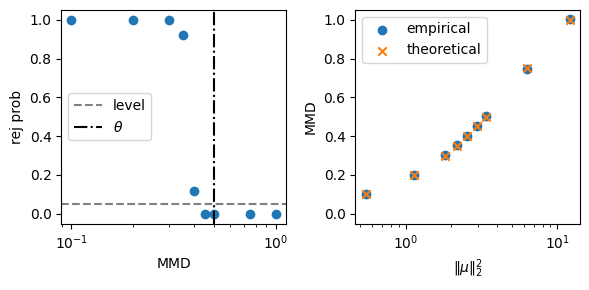

In [167]:
figs, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))

ax = axes[0]
rej_prob = [np.mean(res[kk]["deviation"]["rej"]) for kk in keys]
ax.scatter(keys, rej_prob)
ax.axhline(0.05, color="grey", linestyle="--", label="level")
ax.axvline(theta, color="k", linestyle="-.", label=r"$\theta$")
ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel("MMD")
ax.set_ylabel("rej prob")
ax.legend()

ax = axes[1]
vals = [np.mean(res[kk]["deviation"]["val"]) for kk in keys]
ax.scatter(shift_sq_ls, vals, label="empirical")
ax.scatter(shift_sq_ls, [population_mmd(np.eye(dim)[:1, 0] * s**0.5, 1.) for s in shift_sq_ls], marker="x", label="theoretical")
ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel(r"$\| \mu \|_2^2$")
ax.set_ylabel("MMD")
ax.legend()

_ = plt.tight_layout()

# Bootstrap

In [120]:
np.random.seed(2024)

In [121]:
n = 1000
dim = 1
nrep = 100
# population_mmd_ls = [2e-1, 2.5e-1, 3e-1, 3.5e-1, 4e-1, 4.5e-1, 5e-1, 5.5e-1, 6e-1]
# population_mmd_ls = [4.8e-1, 4.9e-1, 4.95e-1, 5e-1, 5.05e-1, 5.1e-1, 5.2e-1, 5.3e-1]
population_mmd_ls = [2e-1, 3e-1, 4e-1, 5e-1, 6e-1, 7e-1]
# population_mmd_ls = [3e-1, 4e-1, 5e-1, 6e-1]
shift_sq_ls = [population_mmd_inverse(v, dim, 1.) for v in population_mmd_ls]

Xs_ls = []
Ys_ls = []
quantiles = []
stats_all_ls = []

for shift_sq in shift_sq_ls:
    ### Gaussian loc
    mean1 = np.eye(dim)[:1, 0] * shift_sq**0.5
    mean2 = np.zeros((dim,))

    Xs = np.random.multivariate_normal(mean1, np.eye(dim), (nrep*3, n))
    Ys = np.random.multivariate_normal(mean2, np.eye(dim), (nrep, n))
    ###

    Xs_ls.append(Xs[:nrep])
    Ys_ls.append(Ys[:nrep])

    # compute true quantiles
    stat_ls = []
    kernel = kernels.RBF(sigma_sq=2.)
    mmd = metrics.MMD(kernel)
    # Xs = np.random.multivariate_normal(mean1, np.eye(dim), (1000*2, n))
    for i in trange(nrep):
    # for i in trange(1000):
        X, Y = Xs[nrep+i], Xs[2*nrep+i]
        # X, Y = Xs[i], Xs[nrep+i]
        stat_ls.append(mmd(X, Y)**0.5)

    quantile = np.quantile(stat_ls, 0.95)
    quantiles.append(quantile)
    stats_all_ls.append(stat_ls)
            
kernel_class = kernels.RBF

keys = population_mmd_ls

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

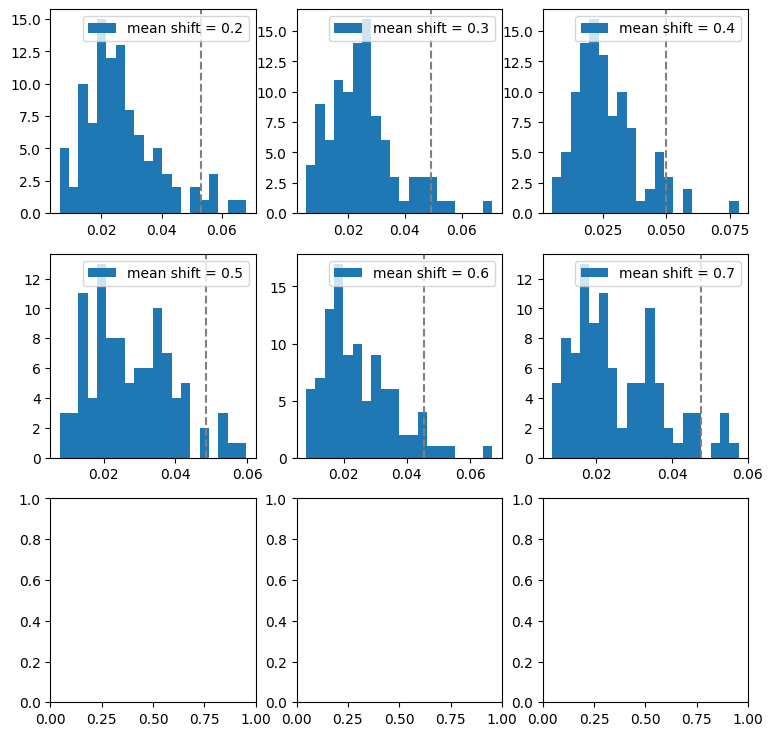

In [122]:
# true sampling distribution
figs, axes = plt.subplots(nrows=3, ncols=3, figsize=(9, 9))

for i, ww in enumerate(population_mmd_ls):
    ax = axes.flatten()[i]
    ax.hist(stats_all_ls[i], bins=20, label=f"mean shift = {ww}")
    ax.axvline(quantiles[i], color="gray", linestyle="--")
    ax.legend()

In [126]:
np.random.seed(2024)

In [127]:
theta = 0.5
res = mmd_experiment(kernel_class, Xs_ls, Ys_ls, theta=theta, keys=keys, quantiles=quantiles)

key: 0.2


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.3


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.4


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.5


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.6


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.7


  0%|          | 0/100 [00:00<?, ?it/s]

In [141]:
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 3))

# rej_prob = [np.mean(res[kk]["deviation"]["rej"]) for kk in keys]
# ax.scatter(keys, rej_prob, label="Deviation")
# ax.axhline(0.05, color="grey", linestyle="--", label="level")
# ax.axvline(theta, color="k", linestyle="-.", label=r"$\theta$")
# # ax.set_xscale("log")
# ax.set_ylim(-0.05, 1.05)
# ax.set_xlabel("MMD")
# ax.set_ylabel("Rejection probability")
# ax.legend()

# _ = plt.tight_layout()
# plt.tight_layout()
# # plt.savefig("../figs/reversed/ms.pdf")

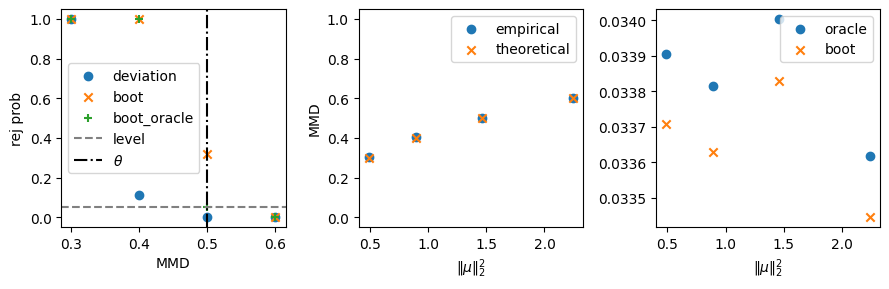

In [84]:
figs, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 3))

ax = axes[0]
rej_prob = [np.mean(res[kk]["deviation"]["rej"]) for kk in keys]
ax.scatter(keys, rej_prob, label="deviation")
rej_prob = [np.mean(res[kk]["boot"]["rej"]) for kk in keys]
ax.scatter(keys, rej_prob, marker="x", label="boot")
rej_prob = [np.mean(res[kk]["boot_oracle"]["rej"]) for kk in keys]
ax.scatter(keys, rej_prob, marker="+", label="boot_oracle")
ax.axhline(0.05, color="grey", linestyle="--", label="level")
ax.axvline(theta, color="k", linestyle="-.", label=r"$\theta$")
# ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel("MMD")
ax.set_ylabel("rej prob")
ax.legend()

ax = axes[1]
vals = [np.mean(res[kk]["deviation"]["val"]) for kk in keys]
ax.scatter(shift_sq_ls, [vv**0.5 for vv in vals], label="empirical")
ax.scatter(shift_sq_ls, [population_mmd(np.eye(dim)[:1, 0] * s**0.5, 1.) for s in shift_sq_ls], marker="x", label="theoretical")
# ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel(r"$\| \mu \|_2^2$")
ax.set_ylabel("MMD")
ax.legend()

ax = axes[2]
quantile_boot = [np.mean(res[kk]["boot"]["threshold"]) for kk in keys]
quantile_oracle = [np.mean(res[kk]["boot_oracle"]["threshold"]) for kk in keys]
ax.scatter(shift_sq_ls, quantile_boot, marker="x", color="C1", label="boot")
ax.scatter(shift_sq_ls, quantile_oracle, marker="+", color="C2", label="oracle")
ax.set_xlabel(r"$\| \mu \|_2^2$")
ax.legend()

_ = plt.tight_layout()
plt.tight_layout()

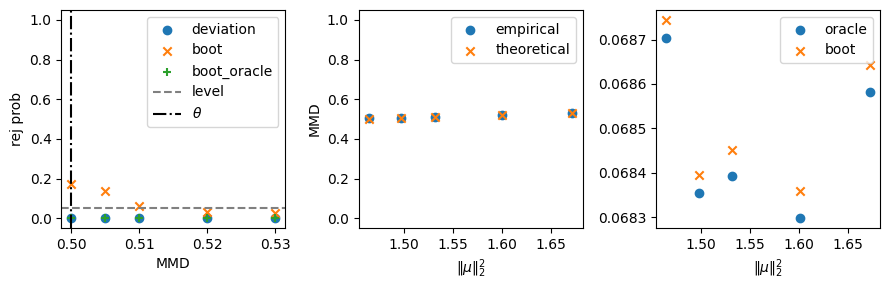

In [102]:
figs, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 3))

ax = axes[0]
rej_prob = [np.mean(res[kk]["deviation"]["rej"]) for kk in keys]
ax.scatter(keys, rej_prob, label="deviation")
rej_prob = [np.mean(res[kk]["boot"]["rej"]) for kk in keys]
ax.scatter(keys, rej_prob, marker="x", label="boot")
rej_prob = [np.mean(res[kk]["boot_oracle"]["rej"]) for kk in keys]
ax.scatter(keys, rej_prob, marker="+", label="boot_oracle")
ax.axhline(0.05, color="grey", linestyle="--", label="level")
ax.axvline(theta, color="k", linestyle="-.", label=r"$\theta$")
# ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel("MMD")
ax.set_ylabel("rej prob")
ax.legend()

ax = axes[1]
vals = [np.mean(res[kk]["deviation"]["val"]) for kk in keys]
ax.scatter(shift_sq_ls, [vv**0.5 for vv in vals], label="empirical")
ax.scatter(shift_sq_ls, [population_mmd(np.eye(dim)[:1, 0] * s**0.5, 1.) for s in shift_sq_ls], marker="x", label="theoretical")
# ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel(r"$\| \mu \|_2^2$")
ax.set_ylabel("MMD")
ax.legend()

ax = axes[2]
quantile_oracle = [np.mean(res[kk]["boot_oracle"]["threshold"]) for kk in keys]
quantile_boot = [np.mean(res[kk]["boot"]["threshold"]) for kk in keys]
ax.scatter(shift_sq_ls, quantile_oracle, label="oracle")
ax.scatter(shift_sq_ls, quantile_boot, marker="x", label="boot")
# ax.set_xscale("log")
ax.set_xlabel(r"$\| \mu \|_2^2$")
ax.legend()

_ = plt.tight_layout()
plt.tight_layout()

# Bootstrap debug

#### level check

In [80]:
np.random.seed(2024)

In [81]:
n = 100 # 1000
dim = 1
nrep = 100
nstats_ora = 2 # 100
population_mmd_ls = [0., 0.2, 0.4, 0.45, 0.5, 0.55, 0.6]

kernel_class = kernels.RBF
keys = population_mmd_ls

data_level = generate_data_and_quantiles(n, dim, population_mmd_ls, nrep, nstats_ora)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [82]:
# level check
np.random.seed(2024)
theta = .5
res_level = mmd_experiment(
    kernels.RBF, data_level["Xs_ls"], data_level["Ys_ls"], theta=theta, keys=keys,
    method="classic",
)

key: 0.0


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.2


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.4


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.45


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.5


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.55


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.6


  0%|          | 0/100 [00:00<?, ?it/s]

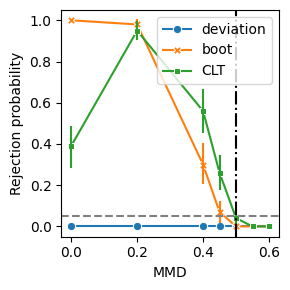

In [83]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))

res_plot = res_level
data_plot = data_level
names = ["deviation_proper", "boot", "CLT"]
rej_df = {"rej": [], "method": [], "xaxis": []}
for nn in names:
    for kk in keys:
        rej_ls = res_plot[kk][nn]["rej"]
        rej_df["rej"] = rej_df["rej"] + rej_ls
        rej_df["method"] = rej_df["method"] + [nn] * len(rej_ls)
        rej_df["xaxis"] = rej_df["xaxis"] + [kk] * len(rej_ls)
rej_df = pd.DataFrame(rej_df)

sns.lineplot(ax=ax, data=rej_df, x="xaxis", y="rej", hue="method", style="method", markers=True, dashes=False, err_style="bars")
ax.axhline(0.05, color="grey", linestyle="--", label="level")
ax.axvline(theta, color="k", linestyle="-.", label=r"$\theta$")
# ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel("MMD")
ax.set_ylabel("Rejection probability")
ax.legend(labels=["deviation", "boot", "CLT"])
# ax.legend([],[], frameon=False)

_ = plt.tight_layout()
plt.tight_layout()
# plt.savefig("../figs/reversed/ms.pdf")

#### Chen et al's setting

In [17]:
np.random.seed(2024)

In [18]:
n = 200 # 50 # 200
dim = 1
nrep = 100
nstats_ora = 1 # 100
mean_ls = [0., 0.1, 0.2, 0.3, 0.4, 0.45] # [0., 0.25, 0.5, 0.75, 1., 1.25, 1.5, 1.75, 2., 2.25] # [1.7, 1.8, 1.9, 2.0, 2.1, 2.2]
mean_vec_ls = [np.eye(dim)[0] * ss for ss in mean_ls]
population_mmd_ls = [population_mmd(vv, bandwidth_sq=1.) for vv in mean_vec_ls]

kernel_class = kernels.RBF
keys = population_mmd_ls

data_level = generate_data_and_quantiles(n, dim, population_mmd_ls, nrep, nstats_ora)

shift_ls: [0.0, 0.09999999999999903, 0.19999999999999968, 0.30000000000000016, 0.39999999999999997, 0.4499999999999998]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [19]:
# level check
np.random.seed(2024)
theta = population_mmd(np.eye(dim)[0] * 0.4, bandwidth_sq=1.)
print("theta:", theta)

res_level = mmd_experiment(
    kernels.RBF, data_level["Xs_ls"], data_level["Ys_ls"], theta=theta, keys=keys,
    method="classic",
)

theta: 0.17431316470355884
key: 0.0


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.043850861304568334


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.08759223997917455


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.13111541235021293


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.17431316470355884


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.19575709834391958


  0%|          | 0/100 [00:00<?, ?it/s]

In [21]:
# import pickle
# pickle.dump(res_level, open("../res/equiv/res_level_d{}_n{}_theta{:.2g}.pkl".format(dim, n, theta), "wb"))

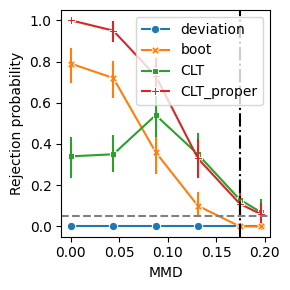

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))

res_plot = res_level
data_plot = data_level
names = ["deviation_proper", "boot", "CLT", "CLT_proper"]
rej_df = {"rej": [], "method": [], "xaxis": []}
for nn in names:
    for kk in keys:
        rej_ls = res_plot[kk][nn]["rej"]
        rej_df["rej"] = rej_df["rej"] + rej_ls
        rej_df["method"] = rej_df["method"] + [nn] * len(rej_ls)
        rej_df["xaxis"] = rej_df["xaxis"] + [kk] * len(rej_ls)
rej_df = pd.DataFrame(rej_df)

sns.lineplot(ax=ax, data=rej_df, x="xaxis", y="rej", hue="method", style="method", markers=True, dashes=False, err_style="bars")
ax.axhline(0.05, color="grey", linestyle="--", label="level")
ax.axvline(theta, color="k", linestyle="-.", label=r"$\theta$")
# ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel("MMD")
ax.set_ylabel("Rejection probability")
ax.legend(labels=["deviation", "boot", "CLT", "CLT_proper"])
# ax.legend([],[], frameon=False)

_ = plt.tight_layout()
plt.tight_layout()
# plt.savefig("../figs/reversed/ms_theta{:.2g}.pdf".format(theta))

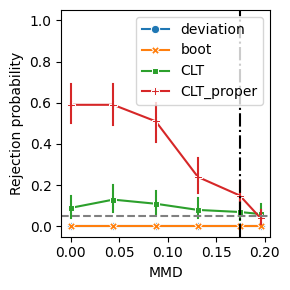

In [324]:
# d1 50n
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))

res_plot = res_level
data_plot = data_level
names = ["deviation_proper", "boot", "CLT", "CLT_proper"]
rej_df = {"rej": [], "method": [], "xaxis": []}
for nn in names:
    for kk in keys:
        rej_ls = res_plot[kk][nn]["rej"]
        rej_df["rej"] = rej_df["rej"] + rej_ls
        rej_df["method"] = rej_df["method"] + [nn] * len(rej_ls)
        rej_df["xaxis"] = rej_df["xaxis"] + [kk] * len(rej_ls)
rej_df = pd.DataFrame(rej_df)

sns.lineplot(ax=ax, data=rej_df, x="xaxis", y="rej", hue="method", style="method", markers=True, dashes=False, err_style="bars")
ax.axhline(0.05, color="grey", linestyle="--", label="level")
ax.axvline(theta, color="k", linestyle="-.", label=r"$\theta$")
# ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel("MMD")
ax.set_ylabel("Rejection probability")
ax.legend(labels=["deviation", "boot", "CLT", "CLT_proper"])
# ax.legend([],[], frameon=False)

_ = plt.tight_layout()
plt.tight_layout()
# plt.savefig("../figs/reversed/ms.pdf")

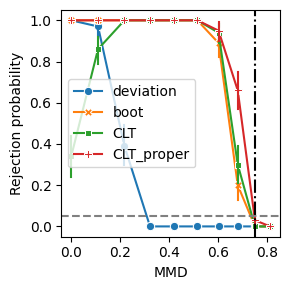

In [293]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))

res_plot = res_level
data_plot = data_level
names = ["deviation_proper", "boot", "CLT", "CLT_proper"]
rej_df = {"rej": [], "method": [], "xaxis": []}
for nn in names:
    for kk in keys:
        rej_ls = res_plot[kk][nn]["rej"]
        rej_df["rej"] = rej_df["rej"] + rej_ls
        rej_df["method"] = rej_df["method"] + [nn] * len(rej_ls)
        rej_df["xaxis"] = rej_df["xaxis"] + [kk] * len(rej_ls)
rej_df = pd.DataFrame(rej_df)

sns.lineplot(ax=ax, data=rej_df, x="xaxis", y="rej", hue="method", style="method", markers=True, dashes=False, err_style="bars")
ax.axhline(0.05, color="grey", linestyle="--", label="level")
ax.axvline(theta, color="k", linestyle="-.", label=r"$\theta$")
# ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel("MMD")
ax.set_ylabel("Rejection probability")
ax.legend(labels=["deviation", "boot", "CLT", "CLT_proper"])
# ax.legend([],[], frameon=False)

_ = plt.tight_layout()
plt.tight_layout()
# plt.savefig("../figs/reversed/ms.pdf")

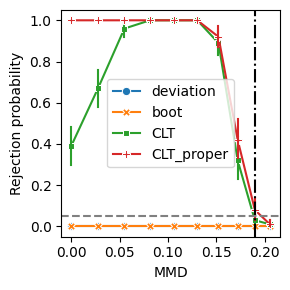

In [299]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))

res_plot = res_level
data_plot = data_level
names = ["deviation_proper", "boot", "CLT", "CLT_proper"]
rej_df = {"rej": [], "method": [], "xaxis": []}
for nn in names:
    for kk in keys:
        rej_ls = res_plot[kk][nn]["rej"]
        rej_df["rej"] = rej_df["rej"] + rej_ls
        rej_df["method"] = rej_df["method"] + [nn] * len(rej_ls)
        rej_df["xaxis"] = rej_df["xaxis"] + [kk] * len(rej_ls)
rej_df = pd.DataFrame(rej_df)

sns.lineplot(ax=ax, data=rej_df, x="xaxis", y="rej", hue="method", style="method", markers=True, dashes=False, err_style="bars")
ax.axhline(0.05, color="grey", linestyle="--", label="level")
ax.axvline(theta, color="k", linestyle="-.", label=r"$\theta$")
# ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel("MMD")
ax.set_ylabel("Rejection probability")
ax.legend(labels=["deviation", "boot", "CLT", "CLT_proper"])
# ax.legend([],[], frameon=False)

_ = plt.tight_layout()
plt.tight_layout()
# plt.savefig("../figs/reversed/ms.pdf")

In [218]:
# res_level_1d = res_level
# data_level_1d = data_level

# res_level = res_level_1d
# data_level = data_level_1d

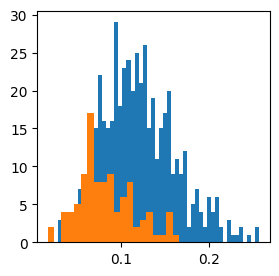

In [219]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))

_ = ax.hist(res_level_1d[keys[0]]["boot"]["boot_stats"][0], bins=50)
_ = ax.hist(data_level_1d["stats_all_ls"][0], bins=20)

In [244]:
# res_level_1d_200n = res_level
# data_level_1d_200n = data_level

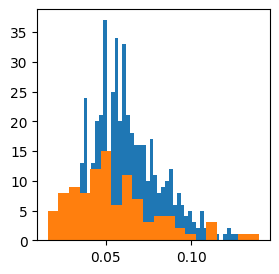

In [245]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))

_ = ax.hist(res_level_1d_200n[keys[0]]["boot"]["boot_stats"][0], bins=50)
_ = ax.hist(np.array(data_level_1d_200n["stats_all_ls"][0]) * 2**0.5, bins=20)

In [214]:
# data_level_6d = data_level
# res_level_6d = res_level

# res_level = res_level_6d
# data_level = data_level_6d

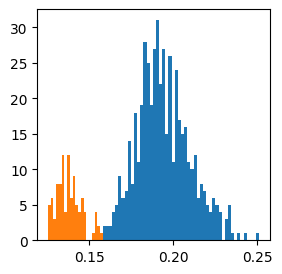

In [220]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))

_ = ax.hist(res_level_6d[keys[0]]["boot"]["boot_stats"][0], bins=50)
_ = ax.hist(data_level_6d["stats_all_ls"][0], bins=20)

In [201]:
theta - res_level[keys[0]]["boot"]["val"][0]

Array(0.01176354, dtype=float32)

In [225]:
np.array(data_level_6d["stats_all_ls"][0])

array([0.13190348, 0.1338523 , 0.14662442, 0.14566652, 0.14013201,
       0.13973686, 0.14159703, 0.14570586, 0.1346404 , 0.1544347 ,
       0.12991327, 0.13321689, 0.13429566, 0.13231592, 0.1369944 ,
       0.14462814, 0.13376737, 0.15198316, 0.13298085, 0.13365252,
       0.13783143, 0.14749873, 0.13867629, 0.12542914, 0.13922937,
       0.14314887, 0.13600986, 0.13513437, 0.137757  , 0.13477558,
       0.12785186, 0.14019418, 0.1409543 , 0.14149898, 0.13195413,
       0.13306277, 0.14068486, 0.12647851, 0.13774286, 0.15363583,
       0.13995834, 0.14336796, 0.13166091, 0.12825297, 0.13071701,
       0.12668094, 0.14501008, 0.12553245, 0.13463661, 0.13210067,
       0.13930908, 0.13733374, 0.13098502, 0.13022998, 0.12830845,
       0.14052679, 0.14251135, 0.1351502 , 0.13462314, 0.14357562,
       0.14757629, 0.14230195, 0.13785422, 0.13722742, 0.14543867,
       0.13313137, 0.13144873, 0.14071505, 0.15329212, 0.13786046,
       0.12778313, 0.12692994, 0.1373553 , 0.13582966, 0.15805

In [224]:
np.mean(theta - res_level[keys[0]]["boot"]["val"][0] > np.array(data_level_6d["stats_all_ls"][0]))

Array(0., dtype=float32)

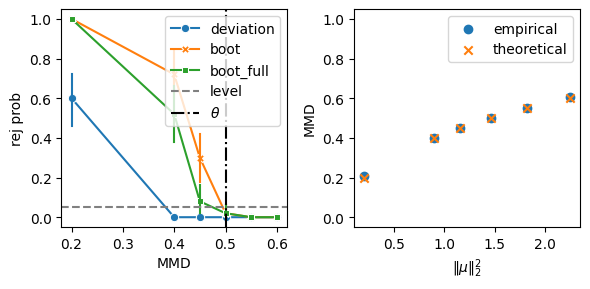

In [321]:
figs, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))

ax = axes[0]
names = ["deviation", "boot", "boot_full", "boot_power"]
# names = ["deviation", "boot_oracle", "boot", "boot_full"]
rej_df = {"rej": [], "method": [], "xaxis": []}
for nn in names:
    for kk in keys:
        rej_ls = res[kk][nn]["rej"]
        rej_df["rej"] = rej_df["rej"] + rej_ls
        rej_df["method"] = rej_df["method"] + [nn] * len(rej_ls)
        rej_df["xaxis"] = rej_df["xaxis"] + [kk] * len(rej_ls)
rej_df = pd.DataFrame(rej_df)

sns.lineplot(ax=ax, data=rej_df, x="xaxis", y="rej", hue="method", style="method", markers=True, dashes=False, err_style="bars")
ax.axhline(0.05, color="grey", linestyle="--", label="level")
ax.axvline(theta, color="k", linestyle="-.", label=r"$\theta$")
ax.axvline(res[keys[0]]["boot_power"]["theta"], color="k", linestyle="-.", label=r"$\theta$'")
# ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel("MMD")
ax.set_ylabel("rej prob")
ax.legend()
# ax.legend([],[], frameon=False)

ax = axes[1]
vals = [np.mean(res[kk]["deviation"]["val"]) for kk in keys]
ax.scatter(shift_sq_ls, [vv for vv in vals], label="empirical")
ax.scatter(shift_sq_ls, [population_mmd(np.eye(dim)[:1, 0] * s**0.5, 1.) for s in shift_sq_ls], marker="x", label="theoretical")
# ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel(r"$\| \mu \|_2^2$")
ax.set_ylabel("MMD")
ax.legend()

_ = plt.tight_layout()
plt.tight_layout()

#### power check

In [325]:
np.random.seed(2024)

In [326]:
n = 200 # 1000
dim = 1
nrep = 100
nstats_ora = 2 # 100
population_mmd_ls = [0., 0.1, 0.2, 0.3, 0.4] # [0., 0.05, 0.1, 0.15, 0.2] # [0., 0.1]

keys = population_mmd_ls

data_power = generate_data_and_quantiles(n, dim, population_mmd_ls, nrep, nstats_ora)

shift_ls: [0.0, 0.22844656215744197, 0.45992549069128336, 0.6977712858439966, 0.9460060987179961]


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]


KeyboardInterrupt



In [ ]:
np.random.seed(2024)
theta = 0.5
# res_power = mmd_experiment(
#     kernels.RBF, data_power["Xs_ls"], data_power["Ys_ls"], theta=theta, keys=keys, beta=0.2, quantiles=data_power["quantiles"],
# )

theta_prime_ls = [0., 0.05, 0.1, 0.15, 0.2]
for theta_prime in theta_prime_ls:
    res_power[theta_prime] = mmd_experiment(
        kernels.RBF, data_power["Xs_ls"], data_power["Ys_ls"], theta=theta, keys=keys, 
        theta_prime=theta_prime, beta=0.2, quantiles=data_power["quantiles"],
    )

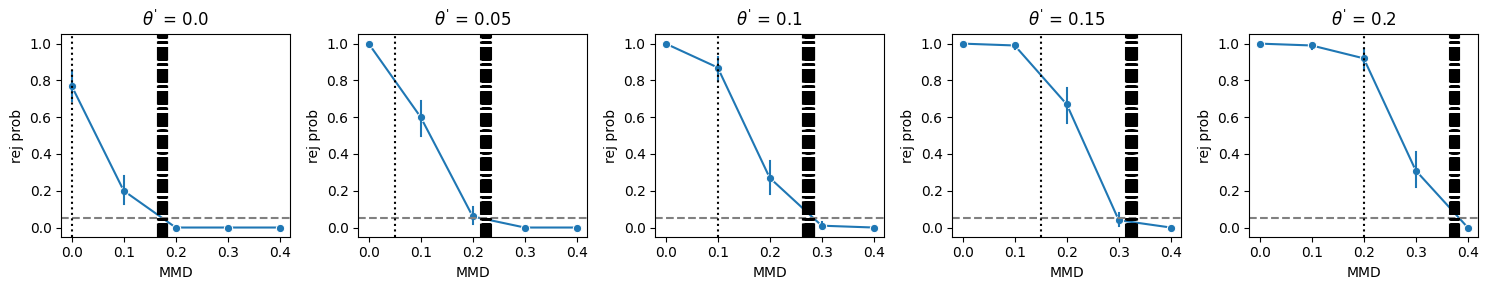

In [181]:
figs, axes = plt.subplots(nrows=1, ncols=len(theta_prime_ls), figsize=(3*len(theta_prime_ls), 3))

for ii, ax in enumerate(axes.flatten()):
    tt = theta_prime_ls[ii]
    rr = res_power[tt]
    
    names = ["boot_power"]
    rej_df = {"rej": [], "method": [], "xaxis": []}
    for nn in names:
        for kk in keys:
            rej_ls = rr[kk][nn]["rej"]
            rej_df["rej"] = rej_df["rej"] + rej_ls
            rej_df["method"] = rej_df["method"] + [nn] * len(rej_ls)
            rej_df["xaxis"] = rej_df["xaxis"] + [kk] * len(rej_ls)
    rej_df = pd.DataFrame(rej_df)
    
    sns.lineplot(ax=ax, data=rej_df, x="xaxis", y="rej", hue="method", style="method", markers=True, dashes=False, err_style="bars")
    ax.axhline(0.05, color="grey", linestyle="--", label="level")
    for xx in rr[keys[0]]["boot_power"]["theta"]:
        ax.axvline(xx, color="k", linestyle="-.")
    ax.axvline(tt, color="k", linestyle=":")
    # ax.set_xscale("log")
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel("MMD")
    ax.set_ylabel("rej prob")
    ax.set_title(rf"$\theta^'$ = {tt}")
    ax.legend()
    ax.legend([],[], frameon=False)

plt.tight_layout()

In [180]:
# import pickle
# pickle.dump(res_power, open("../res/reversed/res_power.pkl", "wb"))

In [203]:
xx = data_power["Xs_ls"][0][0]
kk = kernels.RBF(med_heuristic=True, X=xx, Y=xx)

(200, 1)

In [209]:
np.random.seed(2024)

res_power_orig = mmd_experiment(
    kernels.RBF, data_power["Xs_ls"], data_power["Ys_ls"], theta=theta, keys=keys, 
    beta=0.2, quantiles=data_power["quantiles"], method="original"
)

key: 0.0


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.1


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.2


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.3


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.4


  0%|          | 0/100 [00:00<?, ?it/s]

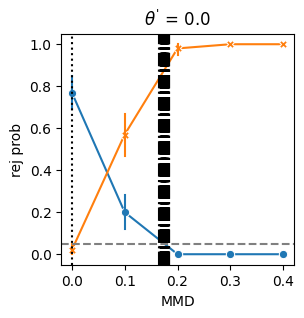

In [210]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))

tt = theta_prime_ls[0]
rr = res_power[tt]

names = ["boot_power"]
rej_df = {"rej": [], "method": [], "xaxis": []}
for nn in names:
    for kk in keys:
        rej_ls = rr[kk][nn]["rej"]
        rej_df["rej"] = rej_df["rej"] + rej_ls
        rej_df["method"] = rej_df["method"] + [nn] * len(rej_ls)
        rej_df["xaxis"] = rej_df["xaxis"] + [kk] * len(rej_ls)

nn = "original"
for kk in keys:
    rej_ls = res_power_orig[kk][nn]["rej"]
    rej_df["rej"] = rej_df["rej"] + rej_ls
    rej_df["method"] = rej_df["method"] + [nn] * len(rej_ls)
    rej_df["xaxis"] = rej_df["xaxis"] + [kk] * len(rej_ls)

rej_df = pd.DataFrame(rej_df)

sns.lineplot(ax=ax, data=rej_df, x="xaxis", y="rej", hue="method", style="method", markers=True, dashes=False, err_style="bars")
ax.axhline(0.05, color="grey", linestyle="--", label="level")
for xx in rr[keys[0]]["boot_power"]["theta"]:
    ax.axvline(xx, color="k", linestyle="-.")
ax.axvline(tt, color="k", linestyle=":")
# ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel("MMD")
ax.set_ylabel("rej prob")
ax.set_title(rf"$\theta^'$ = {tt}")
ax.legend()
ax.legend([],[], frameon=False)

In [ ]:
np.random.seed(2024)

n_list = [10, 50, 100, 200] # [100, 500, 1000, 5000]
dim = 1
nrep = 100
nstats_ora = 2 # 100
population_mmd_ls = [0., 0.1, 0.2, 0.3, 0.4, 0.6, 0.8]

keys = population_mmd_ls

res_power_n = {}
for n in n_list:
    data_power = generate_data_and_quantiles(n, dim, population_mmd_ls, nrep, nstats_ora)
    theta = 0.5
    res_power_n[n] = mmd_experiment(
        kernels.RBF, data_power["Xs_ls"], data_power["Ys_ls"], theta=theta, keys=keys, beta=0.2, quantiles=data_power["quantiles"],
    )

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

key: 0.0


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.1


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.2


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.3


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.4


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.6


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.8


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

key: 0.0


  0%|          | 0/100 [00:00<?, ?it/s]

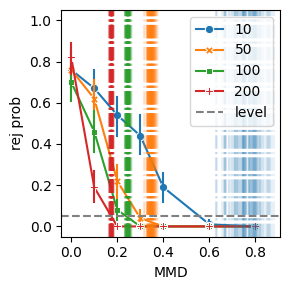

In [239]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))

rej_df = {"rej": [], "method": [], "xaxis": [], "n": []}
nn = "boot_power"    
for n in n_list:
    rr = res_power_n[n]
    for kk in keys:
        rej_ls = rr[kk][nn]["rej"]
        rej_df["rej"] = rej_df["rej"] + rej_ls
        rej_df["method"] = rej_df["method"] + [nn] * len(rej_ls)
        rej_df["xaxis"] = rej_df["xaxis"] + [kk] * len(rej_ls)
        rej_df["n"] = rej_df["n"] + [str(n)] * len(rej_ls)
rej_df = pd.DataFrame(rej_df)
    
sns.lineplot(ax=ax, data=rej_df, x="xaxis", y="rej", hue="n", style="n", markers=True, dashes=False, err_style="bars")
ax.axhline(0.05, color="grey", linestyle="--", label="level")

for i, n in enumerate(n_list):
    rr = res_power_n[n]
    for xx in rr[keys[0]]["boot_power"]["theta"]:
        ax.axvline(xx, color=f"C{i}", linestyle="-.", alpha=0.1)

# ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel("MMD")
ax.set_ylabel("rej prob")
ax.legend()
# ax.legend([],[], frameon=False)

plt.tight_layout()

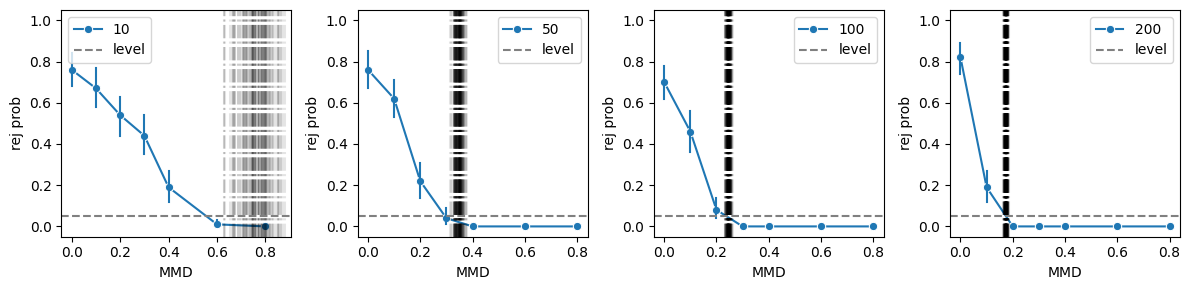

In [244]:
figs, axes = plt.subplots(nrows=1, ncols=len(n_list), figsize=(3*len(n_list), 3))

for n, ax in zip(n_list, axes.flatten()):
    rej_df = {"rej": [], "method": [], "xaxis": [], "n": []}
    nn = "boot_power"    
    rr = res_power_n[n]
    for kk in keys:
        rej_ls = rr[kk][nn]["rej"]
        rej_df["rej"] = rej_df["rej"] + rej_ls
        rej_df["method"] = rej_df["method"] + [nn] * len(rej_ls)
        rej_df["xaxis"] = rej_df["xaxis"] + [kk] * len(rej_ls)
        rej_df["n"] = rej_df["n"] + [str(n)] * len(rej_ls)
    rej_df = pd.DataFrame(rej_df)
        
    sns.lineplot(ax=ax, data=rej_df, x="xaxis", y="rej", hue="n", style="n", markers=True, dashes=False, err_style="bars")
    ax.axhline(0.05, color="grey", linestyle="--", label="level")
    
    for xx in rr[keys[0]]["boot_power"]["theta"]:
        ax.axvline(xx, color="k", linestyle="-.", alpha=0.1)
    
    # ax.set_xscale("log")
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel("MMD")
    ax.set_ylabel("rej prob")
    ax.legend()
    # ax.legend([],[], frameon=False)

plt.tight_layout()

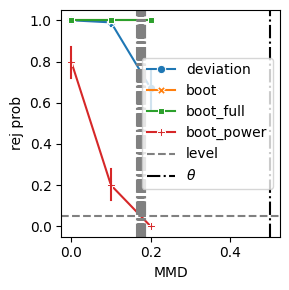

In [162]:
figs, axes = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))

ax = axes
names = ["deviation", "boot", "boot_full", "boot_power"]
# names = ["deviation", "boot_oracle", "boot", "boot_full"]
rej_df = {"rej": [], "method": [], "xaxis": []}
for nn in names:
    for kk in keys:
        rej_ls = res[kk][nn]["rej"]
        rej_df["rej"] = rej_df["rej"] + rej_ls
        rej_df["method"] = rej_df["method"] + [nn] * len(rej_ls)
        rej_df["xaxis"] = rej_df["xaxis"] + [kk] * len(rej_ls)
rej_df = pd.DataFrame(rej_df)

sns.lineplot(ax=ax, data=rej_df, x="xaxis", y="rej", hue="method", style="method", markers=True, dashes=False, err_style="bars")
ax.axhline(0.05, color="grey", linestyle="--", label="level")
ax.axvline(theta, color="k", linestyle="-.", label=r"$\theta$")
for xx in res[keys[0]]["boot_power"]["theta"]:
    ax.axvline(xx, color="gray", linestyle="-.")
# ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel("MMD")
ax.set_ylabel("rej prob")
ax.legend()
# ax.legend([],[], frameon=False)

_ = plt.tight_layout()
plt.tight_layout()

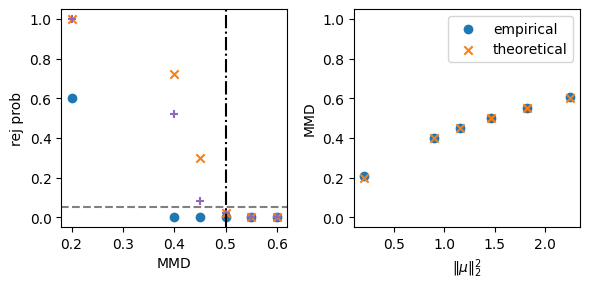

In [322]:
figs, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))

ax = axes[0]
rej_prob = [np.mean(res[kk]["deviation"]["rej"]) for kk in keys]
ax.scatter(keys, rej_prob, label="deviation")
rej_prob = [np.mean(res[kk]["boot_oracle"]["rej"]) for kk in keys]
# ax.scatter(keys, rej_prob, marker="s", label="boot_oracle")
rej_prob = [np.mean(res[kk]["boot"]["rej"]) for kk in keys]
ax.scatter(keys, rej_prob, marker="x", label="boot")
rej_prob = [np.mean(res[kk]["boot_full"]["rej"]) for kk in keys]
ax.scatter(keys, rej_prob, marker="+", label="boot_full", color="C4")
ax.axhline(0.05, color="grey", linestyle="--", label="level")
ax.axvline(theta, color="k", linestyle="-.", label=r"$\theta$")
# ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel("MMD")
ax.set_ylabel("rej prob")
# ax.legend()
    
ax = axes[1]
vals = [np.mean(res[kk]["deviation"]["val"]) for kk in keys]
ax.scatter(shift_sq_ls, [vv for vv in vals], label="empirical")
ax.scatter(shift_sq_ls, [population_mmd(np.eye(dim)[:1, 0] * s**0.5, 1.) for s in shift_sq_ls], marker="x", label="theoretical")
# ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel(r"$\| \mu \|_2^2$")
ax.set_ylabel("MMD")
ax.legend()

_ = plt.tight_layout()
plt.tight_layout()

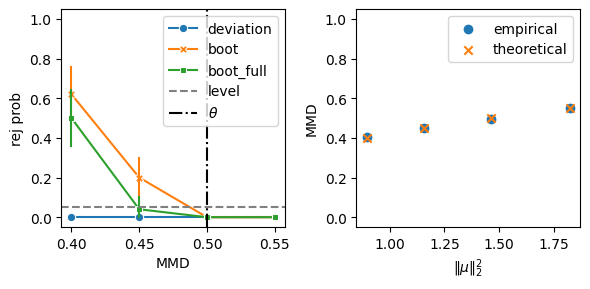

In [313]:
figs, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))

ax = axes[0]
names = ["deviation", "boot", "boot_full"] # ["deviation", "boot_oracle", "boot", "boot_full"]
rej_df = {"rej": [], "method": [], "xaxis": []}
for nn in names:
    for kk in keys:
        rej_ls = res[kk][nn]["rej"]
        rej_df["rej"] = rej_df["rej"] + rej_ls
        rej_df["method"] = rej_df["method"] + [nn] * len(rej_ls)
        rej_df["xaxis"] = rej_df["xaxis"] + [kk] * len(rej_ls)
rej_df = pd.DataFrame(rej_df)

sns.lineplot(ax=ax, data=rej_df, x="xaxis", y="rej", hue="method", style="method", markers=True, dashes=False, err_style="bars")
ax.axhline(0.05, color="grey", linestyle="--", label="level")
ax.axvline(theta, color="k", linestyle="-.", label=r"$\theta$")
# ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel("MMD")
ax.set_ylabel("rej prob")
ax.legend()
# ax.legend([],[], frameon=False)

ax = axes[1]
vals = [np.mean(res[kk]["deviation"]["val"]) for kk in keys]
ax.scatter(shift_sq_ls, [vv for vv in vals], label="empirical")
ax.scatter(shift_sq_ls, [population_mmd(np.eye(dim)[:1, 0] * s**0.5, 1.) for s in shift_sq_ls], marker="x", label="theoretical")
# ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel(r"$\| \mu \|_2^2$")
ax.set_ylabel("MMD")
ax.legend()

_ = plt.tight_layout()
plt.tight_layout()

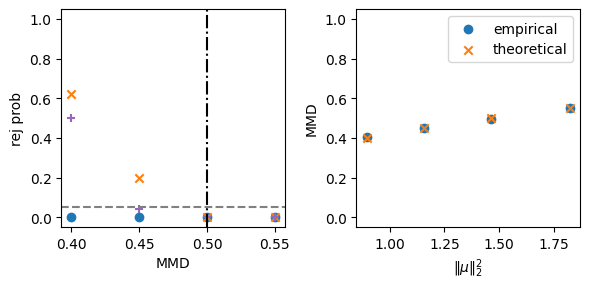

In [314]:
figs, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))

ax = axes[0]
rej_prob = [np.mean(res[kk]["deviation"]["rej"]) for kk in keys]
ax.scatter(keys, rej_prob, label="deviation")
rej_prob = [np.mean(res[kk]["boot_oracle"]["rej"]) for kk in keys]
# ax.scatter(keys, rej_prob, marker="s", label="boot_oracle")
rej_prob = [np.mean(res[kk]["boot"]["rej"]) for kk in keys]
ax.scatter(keys, rej_prob, marker="x", label="boot")
rej_prob = [np.mean(res[kk]["boot_full"]["rej"]) for kk in keys]
ax.scatter(keys, rej_prob, marker="+", label="boot_full", color="C4")
ax.axhline(0.05, color="grey", linestyle="--", label="level")
ax.axvline(theta, color="k", linestyle="-.", label=r"$\theta$")
# ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel("MMD")
ax.set_ylabel("rej prob")
# ax.legend()

ax = axes[1]
vals = [np.mean(res[kk]["deviation"]["val"]) for kk in keys]
ax.scatter(shift_sq_ls, [vv for vv in vals], label="empirical")
ax.scatter(shift_sq_ls, [population_mmd(np.eye(dim)[:1, 0] * s**0.5, 1.) for s in shift_sq_ls], marker="x", label="theoretical")
# ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel(r"$\| \mu \|_2^2$")
ax.set_ylabel("MMD")
ax.legend()

_ = plt.tight_layout()
plt.tight_layout()

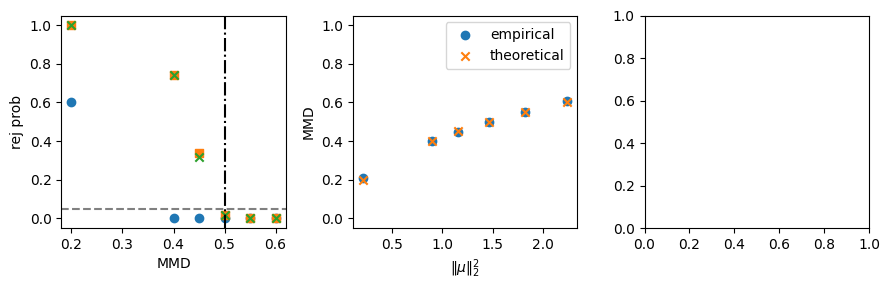

In [207]:
figs, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 3))

ax = axes[0]
rej_prob = [np.mean(res[kk]["deviation"]["rej"]) for kk in keys]
ax.scatter(keys, rej_prob, label="deviation")
rej_prob = [np.mean(res[kk]["boot_oracle"]["rej"]) for kk in keys]
ax.scatter(keys, rej_prob, marker="s", label="boot_oracle")
rej_prob = [np.mean(res[kk]["boot"]["rej"]) for kk in keys]
ax.scatter(keys, rej_prob, marker="x", label="boot")
ax.axhline(0.05, color="grey", linestyle="--", label="level")
ax.axvline(theta, color="k", linestyle="-.", label=r"$\theta$")
# ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel("MMD")
ax.set_ylabel("rej prob")
# ax.legend()

ax = axes[1]
vals = [np.mean(res[kk]["deviation"]["val"]) for kk in keys]
ax.scatter(shift_sq_ls, [vv for vv in vals], label="empirical")
ax.scatter(shift_sq_ls, [population_mmd(np.eye(dim)[:1, 0] * s**0.5, 1.) for s in shift_sq_ls], marker="x", label="theoretical")
# ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel(r"$\| \mu \|_2^2$")
ax.set_ylabel("MMD")
ax.legend()

# ax = axes[2]
# # quantile_oracle = [np.mean(res[kk]["boot_oracle"]["threshold"]) for kk in keys]
# # quantile_boot = [np.mean(res[kk]["boot"]["threshold"]) for kk in keys]
# # ax.scatter(shift_sq_ls, quantile_oracle, label="oracle")
# # ax.scatter(shift_sq_ls, quantile_boot, marker="x", label="boot")
# # # ax.set_xscale("log")
# # ax.set_xlabel(r"$\| \mu \|_2^2$")
# # ax.legend()

# ax.hist(res[keys[0]]["boot"]["boot_stats"][0], bins=50)
# ax.axvline(res[keys[0]]["boot_oracle"]["threshold"][0], color="C0", linestyle="--", label="oracle quantile")
# ax.axvline(res[keys[0]]["boot"]["threshold"][0], color="C1", linestyle="--", label="boot quantile")

_ = plt.tight_layout()
plt.tight_layout()

#### High-dim

In [116]:
np.random.seed(2024)

In [117]:
n = 200 # 1000
dim_ls = [1, 2, 8, 16]
nrep = 50
shift_ls = [0., 0.5, 1., 5., 10.] # [0., 0.5, 1., 5., 10.]
# population_mmd_ls = [0., 0.1, 0.2, 0.3, 0.4]

keys = shift_ls
# kerys = population_mmd_ls

# theta = 0.2
theta_prime = 0.05

res_dim = {}

for dim in dim_ls:
    mean_ls = [np.ones((dim,)) * ss for ss in shift_ls]
    # mean_ls = [np.eye(dim)[0] * ss**0.5 for ss in shift_ls]
    # population_mmd_ls = [population_mmd(mm, bandwidth_sq=1.) for mm in mean_ls]
    
    data_dim = generate_data_and_quantiles(n, dim, population_mmd_ls=None, mean_ls=mean_ls, nrep=nrep, nstats_ora=None)
    
    res_dim[dim] = mmd_experiment(
        kernels.RBF, data_dim["Xs_ls"], data_dim["Ys_ls"], theta=theta, keys=keys, 
        theta_prime=theta_prime, beta=0.2, quantiles=None,
    )

mean_ls [[ 0. ]
 [ 0.5]
 [ 1. ]
 [ 5. ]
 [10. ]]
key: 0.0


  0%|          | 0/50 [00:00<?, ?it/s]

key: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

key: 1.0


  0%|          | 0/50 [00:00<?, ?it/s]

key: 5.0


  0%|          | 0/50 [00:00<?, ?it/s]

key: 10.0


  0%|          | 0/50 [00:00<?, ?it/s]

mean_ls [[ 0.   0. ]
 [ 0.5  0.5]
 [ 1.   1. ]
 [ 5.   5. ]
 [10.  10. ]]
key: 0.0


  0%|          | 0/50 [00:00<?, ?it/s]

key: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

key: 1.0


  0%|          | 0/50 [00:00<?, ?it/s]

key: 5.0


  0%|          | 0/50 [00:00<?, ?it/s]

key: 10.0


  0%|          | 0/50 [00:00<?, ?it/s]

mean_ls [[ 0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5]
 [ 1.   1.   1.   1.   1.   1.   1.   1. ]
 [ 5.   5.   5.   5.   5.   5.   5.   5. ]
 [10.  10.  10.  10.  10.  10.  10.  10. ]]
key: 0.0


  0%|          | 0/50 [00:00<?, ?it/s]

key: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

key: 1.0


  0%|          | 0/50 [00:00<?, ?it/s]

key: 5.0


  0%|          | 0/50 [00:00<?, ?it/s]

key: 10.0


  0%|          | 0/50 [00:00<?, ?it/s]

mean_ls [[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. ]
 [ 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
   0.5  0.5]
 [ 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
   1.   1. ]
 [ 5.   5.   5.   5.   5.   5.   5.   5.   5.   5.   5.   5.   5.   5.
   5.   5. ]
 [10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.
  10.  10. ]]
key: 0.0


  0%|          | 0/50 [00:00<?, ?it/s]

key: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

key: 1.0


  0%|          | 0/50 [00:00<?, ?it/s]

key: 5.0


  0%|          | 0/50 [00:00<?, ?it/s]

key: 10.0


  0%|          | 0/50 [00:00<?, ?it/s]

In [119]:
tt = dim_ls[3]
rr = res_dim[tt]

names = ["boot_power"]
rej_df = {"rej": [], "method": [], "xaxis": [], "mmd": []}
for nn in names:
    for kk in keys:
        rej_ls = rr[kk][nn]["rej"]
        rej_df["rej"] = rej_df["rej"] + rej_ls
        rej_df["method"] = rej_df["method"] + [nn] * len(rej_ls)
        rej_df["xaxis"] = rej_df["xaxis"] + [kk] * len(rej_ls)
        rej_df["mmd"] = rej_df["mmd"] + np.array(rr[kk][nn]["val"]).tolist()
rej_df = pd.DataFrame(rej_df)
rej_df

,rej,method,xaxis,mmd
0,1.0,boot_power,0.0,0.100105
1,1.0,boot_power,0.0,0.100129
2,1.0,boot_power,0.0,0.099969
3,1.0,boot_power,0.0,0.099818
4,1.0,boot_power,0.0,0.100221
...,...,...,...,...
245,1.0,boot_power,10.0,0.101263
246,1.0,boot_power,10.0,0.101409
247,1.0,boot_power,10.0,0.101586
248,1.0,boot_power,10.0,0.101421


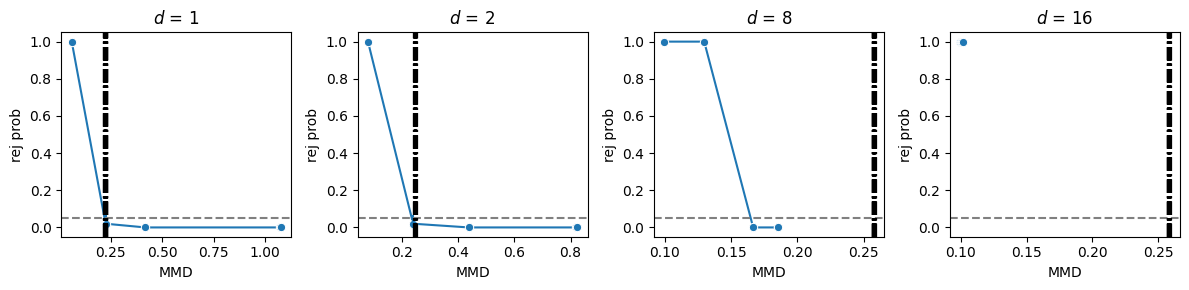

In [121]:
figs, axes = plt.subplots(nrows=1, ncols=len(dim_ls), figsize=(3*len(dim_ls), 3))

for ii, ax in enumerate(axes.flatten()):
    tt = dim_ls[ii]
    rr = res_dim[tt]
    
    names = ["boot_power"]
    rej_df = {"rej": [], "method": [], "xaxis": [], "mmd": []}
    for nn in names:
        for kk in keys:
            rej_ls = rr[kk][nn]["rej"]
            rej_df["rej"] = rej_df["rej"] + rej_ls
            rej_df["method"] = rej_df["method"] + [nn] * len(rej_ls)
            rej_df["xaxis"] = rej_df["xaxis"] + [kk] * len(rej_ls)
            # rej_df["mmd"] = rej_df["mmd"] + np.array(rr[kk][nn]["val"]).tolist()
            rej_df["mmd"] = rej_df["mmd"] + [np.mean(rr[kk][nn]["val"])] * len(rej_ls)
    rej_df = pd.DataFrame(rej_df)
    
    sns.lineplot(ax=ax, data=rej_df, x="mmd", y="rej", hue="method", style="method", markers=True, dashes=False, err_style="bars")
    ax.axhline(0.05, color="grey", linestyle="--", label="level")
    for xx in rr[keys[0]]["boot_power"]["theta"]:
        ax.axvline(xx, color="k", linestyle="-.")
    # ax.axvline(tt, color="k", linestyle=":")
    # ax.set_xscale("log")
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel("MMD")
    ax.set_ylabel("rej prob")
    ax.set_title(rf"$d$ = {tt}")
    ax.legend()
    ax.legend([],[], frameon=False)

plt.tight_layout()

# Debug bootstrap deviation

In [248]:
def debug_bootstrap(shift_sq_ls, nrep, n, dim, ora_size=None, nstats_ora=100, nboot=100):
    Xs_ls = []
    Ys_ls = []
    stats_all_ls = []

    res = {"shift_sq": shift_sq_ls, "Xs": [], "Ys": [], "quantile": [], "boot_quantile": [], "boot_ora_quantile": [],
           "true_stats": [], "boot_stats": [], "boot_ora_stats": [],
           "Y": []}
    
    for shift_sq in shift_sq_ls:
        print("shift_sq", shift_sq)
        ### Gaussian loc
        mean1 = np.eye(dim)[0] * shift_sq**0.5
        # mean2 = np.zeros((dim,))

        ora_size = n * 5 if ora_size is None else ora_size
        Y = np.random.multivariate_normal(mean1, np.eye(dim), (ora_size,))
        
        Xs = np.random.multivariate_normal(mean1, np.eye(dim), (nrep, n))

        Xs = jnp.array(Xs)
        ###
    
        Xs_ls.append(Xs)

        # 1. true quantiles
        quantiles = []
        iterator = trange(1)
        for _ in iterator:
            Xs = np.random.multivariate_normal(mean1, np.eye(dim), (nstats_ora, n))
            
            stat_ls = []
            kernel = kernels.RBF(sigma_sq=2.)
            mmd = metrics.MMD(kernel)
            for i in range(Xs.shape[0]):
                iterator.set_description(f"[{i+1} / {Xs.shape[0]}]")
                X = Xs[i]
                stat_ls.append(mmd(X, Y))
        
            quantile = np.quantile(stat_ls, 0.95)
            quantiles.append(quantile)
            res["true_stats"].append(stat_ls)
        res["quantile"].append(quantiles)

        # 2. bootstrap quantiles
        boot_quantiles = []
        boot_ora_quantiles = []
        kernel = kernels.RBF(sigma_sq=2.)
        mmd = metrics.MMD(kernel)

        for X in tqdm(Xs_ls[-1], total=Xs_ls[-1].shape[0]):
            boot_stats = mmd.test_threshold(X.shape[0], X, nboot=nboot, method="bootstrap_efron")
            boot_stats = np.array(boot_stats)
            boot_quantile = np.quantile(boot_stats, 0.95)
            boot_quantiles.append(boot_quantile)
            res["boot_stats"].append(boot_stats)

        res["boot_quantile"].append(boot_quantiles)
    
    return res

In [249]:
np.random.seed(2024)

In [250]:
n = 50 # 200 # 1000
dim = 6
nrep = 1
population_mmd_ls = [0.] # [3e-1, 4e-1, 5e-1, 6e-1]
shift_sq_ls = [population_mmd_inverse(v, dim, 1.) for v in population_mmd_ls]

keys = population_mmd_ls

res_boot = debug_bootstrap(shift_sq_ls, nrep=nrep, n=n, dim=dim, ora_size=5000, nboot=500, nstats_ora=500)

shift_sq -0.0


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [234]:
# import pickle 
# pickle.dump(res, open("../res/reversed/boot_res.pkl", "wb"))
# pickle.dump(res, open("../res/reversed/boot_res_empirical.pkl", "wb"))

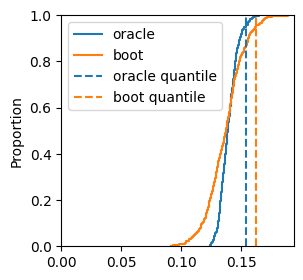

In [251]:
# n = 50, d = 6
# CDF of stats
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(3, 3))

ora_quantile = [np.mean(r) for r in res_boot["quantile"]]
boot_quantile = [np.mean(r) for r in res_boot["boot_quantile"]]
sns.ecdfplot(ax=ax, data=np.array(res_boot["true_stats"][0])**0.5, label="oracle")
sns.ecdfplot(ax=ax, data=np.array(res_boot["boot_stats"][0])**0.5, label="boot")
ax.axvline(ora_quantile[0]**0.5, color="C0", linestyle="--", label="oracle quantile")
ax.axvline(boot_quantile[0]**0.5, color="C1", linestyle="--", label="boot quantile")
ax.set_xlim(0)

ax.legend()

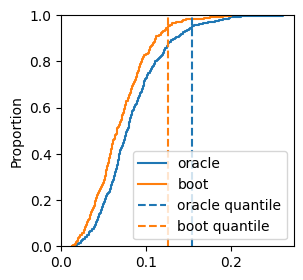

In [235]:
# n = 50, d = 1
# CDF of stats
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(3, 3))

ora_quantile = [np.mean(r) for r in res_boot["quantile"]]
boot_quantile = [np.mean(r) for r in res_boot["boot_quantile"]]
sns.ecdfplot(ax=ax, data=np.array(res_boot["true_stats"][0])**0.5, label="oracle")
sns.ecdfplot(ax=ax, data=np.array(res_boot["boot_stats"][0])**0.5, label="boot")
ax.axvline(ora_quantile[0]**0.5, color="C0", linestyle="--", label="oracle quantile")
ax.axvline(boot_quantile[0]**0.5, color="C1", linestyle="--", label="boot quantile")
ax.set_xlim(0)

ax.legend()

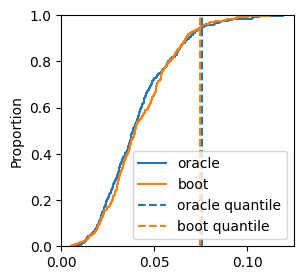

In [175]:
# n = 200, d = 1
# CDF of stats
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(3, 3))

ora_quantile = [np.mean(r) for r in res_boot["quantile"]]
boot_quantile = [np.mean(r) for r in res_boot["boot_quantile"]]
sns.ecdfplot(ax=ax, data=np.array(res_boot["true_stats"][0])**0.5, label="oracle")
sns.ecdfplot(ax=ax, data=np.array(res_boot["boot_stats"][0])**0.5, label="boot")
ax.axvline(ora_quantile[0]**0.5, color="C0", linestyle="--", label="oracle quantile")
ax.axvline(boot_quantile[0]**0.5, color="C1", linestyle="--", label="boot quantile")
ax.set_xlim(0)

ax.legend()

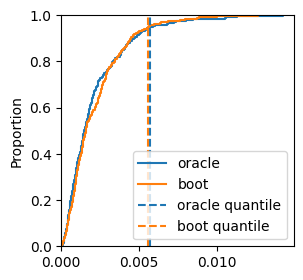

In [178]:
# CDF of stats
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(3, 3))

ora_quantile = [np.mean(r) for r in res_boot["quantile"]]
boot_quantile = [np.mean(r) for r in res_boot["boot_quantile"]]
sns.ecdfplot(ax=ax, data=np.array(res_boot["true_stats"][0]), label="oracle")
sns.ecdfplot(ax=ax, data=np.array(res_boot["boot_stats"][0]), label="boot")
ax.axvline(ora_quantile[0], color="C0", linestyle="--", label="oracle quantile")
ax.axvline(boot_quantile[0], color="C1", linestyle="--", label="boot quantile")
ax.set_xlim(0)

ax.legend()

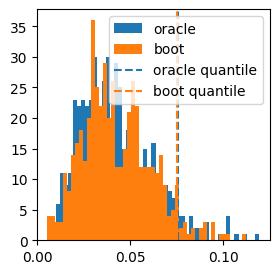

In [157]:
# CDF of stats
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(3, 3))

ora_quantile = [np.mean(r) for r in res_boot["quantile"]]
boot_quantile = [np.mean(r) for r in res_boot["boot_quantile"]]
ax.hist(np.array(res_boot["true_stats"][0])**0.5, bins=50, label="oracle")
ax.hist(np.array(res_boot["boot_stats"][0])**0.5, bins=50, label="boot")
ax.axvline(ora_quantile[0]**0.5, color="C0", linestyle="--", label="oracle quantile")
ax.axvline(boot_quantile[0]**0.5, color="C1", linestyle="--", label="boot quantile")
ax.set_xlim(0)

ax.legend()

In [166]:
print("oracle", ora_quantile[0]**0.5)
print("boot  ", boot_quantile[0]**0.5)

oracle 0.07562418913603572
boot   0.07491267206435458


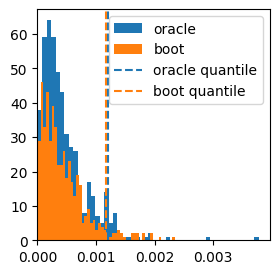

In [116]:
# CDF of stats
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(3, 3))

ora_quantile = [np.mean(r) for r in res_boot["quantile"]]
boot_quantile = [np.mean(r) for r in res_boot["boot_quantile"]]
ax.hist(res_boot["true_stats"][0], bins=50, label="oracle")
ax.hist(res_boot["boot_stats"][0], bins=50, label="boot")
# ax.hist(res["boot_ora_stats"][0], bins=10, label="boot_ora")
# test_stat_oracle = np.mean(res["true_stats"][0])
# ax.hist(res["boot_stats"][0] - test_stat_oracle, bins=10, label="boot")
ax.axvline(ora_quantile[0], color="C0", linestyle="--", label="oracle quantile")
ax.axvline(boot_quantile[0], color="C1", linestyle="--", label="boot quantile")
ax.set_xlim(0)

ax.legend()

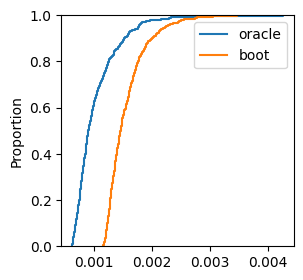

In [86]:
# CDF of stats
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(3, 3))

ora_quantile = [np.mean(r) for r in res["quantile"]]
boot_quantile = [np.mean(r) for r in res["boot_quantile"]]
sns.ecdfplot(ax=ax, data=np.array(res["true_stats"][0]), label="oracle")
sns.ecdfplot(ax=ax, data=np.array(res["boot_stats"][0]), label="boot")

ax.legend()

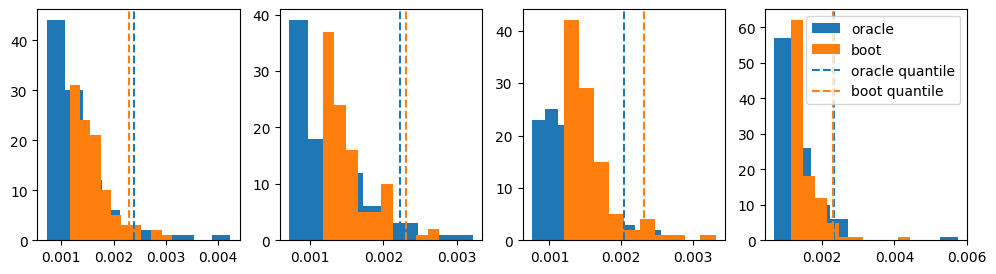

In [241]:
# CDF of stats
figs, axes = plt.subplots(ncols=len(res["quantile"]), nrows=1, figsize=(len(res["quantile"])*3, 3))

ora_quantile = [np.mean(r) for r in res["quantile"]]
boot_quantile = [np.mean(r) for r in res["boot_quantile"]]
for i, ax in enumerate(axes.flatten()):
    ax.hist(res["true_stats"][i], bins=10, label="oracle")
    ax.hist(res["boot_stats"][i], bins=10, label="boot")
    ax.axvline(ora_quantile[i], color="C0", linestyle="--", label="oracle quantile")
    ax.axvline(boot_quantile[i], color="C1", linestyle="--", label="boot quantile")

ax.legend()

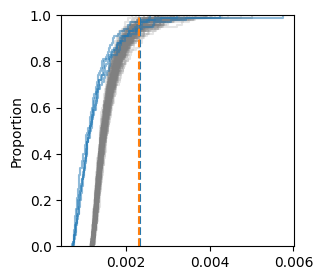

In [253]:
# CDF of stats
figs, axes = plt.subplots(ncols=1, nrows=1, figsize=(3, 3))

ora_quantile = [np.mean(r) for r in res["quantile"]]
boot_quantile = [np.mean(r) for r in res["boot_quantile"]]

ax = axes
for i in range(100):
    sns.ecdfplot(ax=ax, data=np.array(res["boot_stats"][i]), label="boot", alpha=0.2, color="grey")

for i in range(4):
    sns.ecdfplot(ax=ax, data=np.array(res["true_stats"][i]), label="oracle", alpha=0.5, color="C0")

ax.axvline(ora_quantile[i], color="C0", linestyle="--", label="oracle quantile")
ax.axvline(boot_quantile[i], color="C1", linestyle="--", label="boot quantile")
    
# ax.legend()

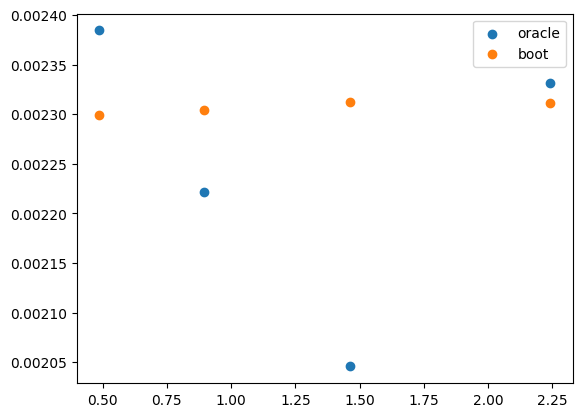

In [239]:
fig, ax = plt.subplots(ncols=1, nrows=1)

ora_quantile = [np.mean(r) for r in res["quantile"]]
boot_quantile = [np.mean(r) for r in res["boot_quantile"]]
_ = ax.scatter(res["shift_sq"], ora_quantile, label="oracle")
_ = ax.scatter(res["shift_sq"], boot_quantile, label="boot")
ax.legend()

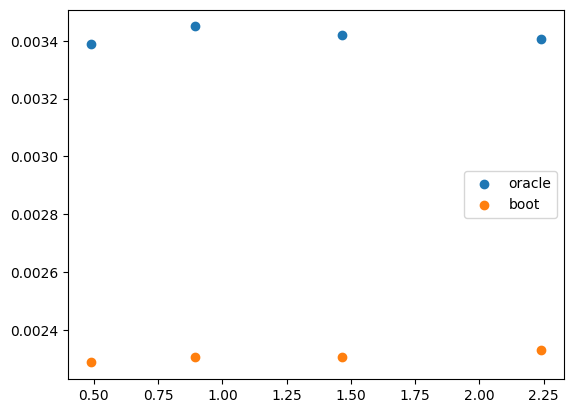

In [170]:
fig, ax = plt.subplots(ncols=1, nrows=1)

ora_quantile = [np.mean(r) for r in res["quantile"]]
boot_quantile = [np.mean(r) for r in res["boot_quantile"]]
_ = ax.scatter(res["shift_sq"], ora_quantile, label="oracle")
_ = ax.scatter(res["shift_sq"], boot_quantile, label="boot")
ax.legend()

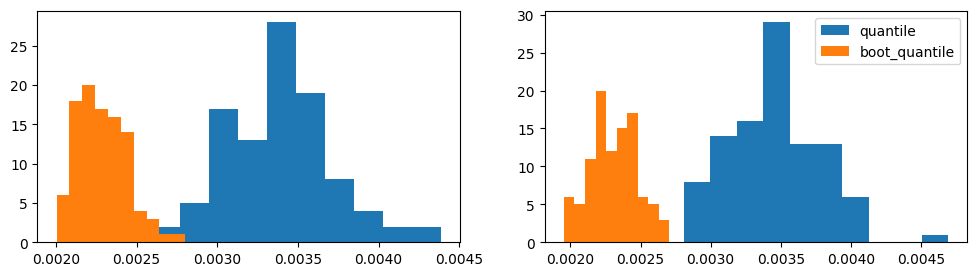

In [182]:
# CDF of quantiles
figs, axes = plt.subplots(ncols=len(res["quantile"]), nrows=1, figsize=(len(res["quantile"])*3, 3))

for i, ax in enumerate(axes.flatten()):
    ax.hist(res["quantile"][i], bins=10, label="quantile")
    ax.hist(res["boot_quantile"][i], bins=10, label="boot_quantile")

ax.legend()

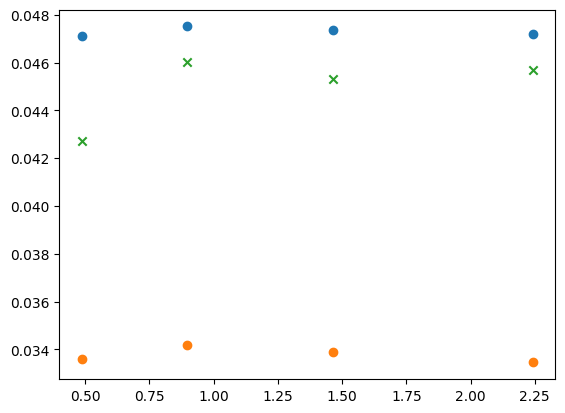

In [118]:
fig, ax = plt.subplots(ncols=1, nrows=1)

ora_quantile = [np.mean(r) for r in res["quantile"]]
boot_quantile = [np.mean(r) for r in res["boot_quantile"]]
boot_ora_quantile = [np.mean(r) for r in res["boot_ora_quantile"]]
_ = ax.scatter(res["shift_sq"], ora_quantile, label="oracle")
_ = ax.scatter(res["shift_sq"], boot_quantile, label="boot")
_ = ax.scatter(res["shift_sq"], boot_ora_quantile, marker="x", label="boot_ora")
ax.legend()

In [157]:
np.sqrt(0.95 * 0.05 / 1000)

0.006892024376045111